# Change Point Detection in Vehicle Data using Time Series and ML

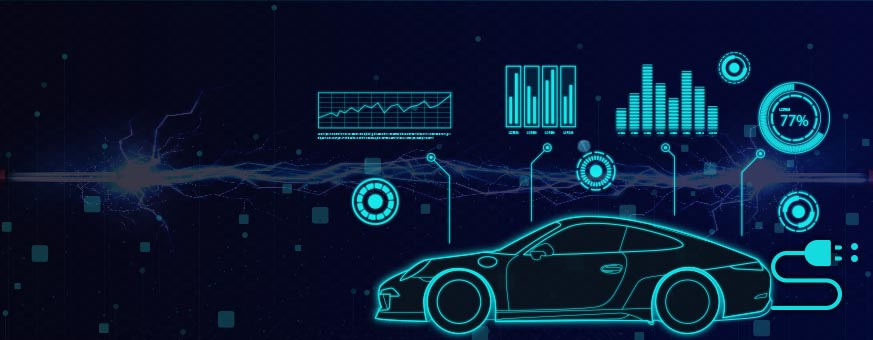

-----
-----

### Problem Statement
   **_Our aim is set to use the dataset on various vehicle parameters, develop a model to detect the quantity of fuel filled 
and identify instances of fuel fill and Fuel pilferage_**


#### **Steps that have been taken:**

_• Data Cleaning & Exploration:_ We have conducted a thorough cleansing process followed by exploration of the dataset to gain an understanding of its structure, quality, and potential issues.

_• Data Preparation:_ Afterwards we went for pre-processing the data to prepare it for training and testing. This may involve steps such as normalization, feature engineering, and handling missing values.

_• Model Development:_ Next comes the development of a model to detect the quantity of fuel filled and identify instances of 
fuel pilferage. The model architecture and relevant hyperparameters have been carefully selected based on the problem statement and the data.

_• Model Evaluation:_ We employed some appropriate metrics to evaluate the performance of the model as well reported the performance of the model on the test data.

_• Interpretation and Visualization:_ Next we interpreted the results of the model and visualized them in a way that is 
easily understandable to the end-users.


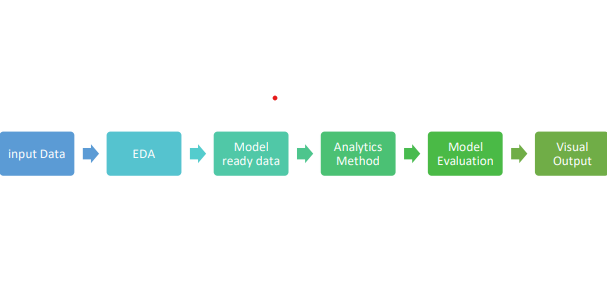

## Data Description:

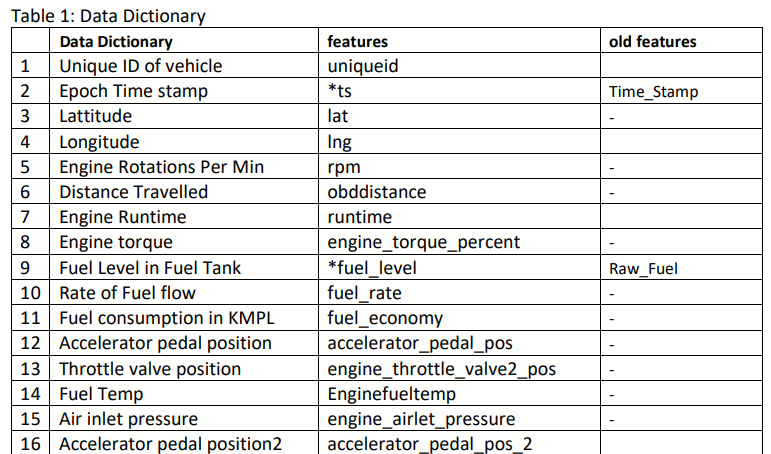


###                                                    [Click here to download the vehicle dataset](https://docs.google.com/spreadsheets/d/1Si9zK2pb0zCv56JPKjWt1PkBwKsac0XU/edit?usp=drive_link&ouid=103092036297574443808&rtpof=true&sd=true)


---
---

In [1]:
# Loading all the dependencies

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from geopy.geocoders import Nominatim
from changefinder import ChangeFinder
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

In [2]:
data = pd.read_excel('Downloads/Data_Engineer_test_DataSet.xlsx',engine='openpyxl')

## Entire data walk through

In [3]:
# Metadata of our dataset

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60397 entries, 0 to 60396
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   uniqueid                    60397 non-null  object 
 1   ts                          60397 non-null  int64  
 2   lat                         60397 non-null  float64
 3   lng                         60397 non-null  float64
 4   rpm                         53356 non-null  float64
 5   obddistance                 60371 non-null  float64
 6   runtime                     60384 non-null  float64
 7   engine_torque_percent       46595 non-null  float64
 8   fuel_level                  60208 non-null  float64
 9   fuel_rate                   46415 non-null  float64
 10  fuel_economy                55528 non-null  float64
 11  fuel_consumption            0 non-null      float64
 12  accelerator_pedal_pos       36216 non-null  float64
 13  engine_throttle_valve2_pos  603

In [4]:
data.describe()

,ts,lat,lng,rpm,obddistance,runtime,engine_torque_percent,fuel_level,fuel_rate,fuel_economy,fuel_consumption,accelerator_pedal_pos,engine_throttle_valve2_pos,enginefueltemp,engine_airlet_pressure,accelerator_pedal_pos_2
count,6.039700e+04,60397.000000,60397.000000,53356.000000,6.037100e+04,60384.000000,46595.000000,60208.000000,46415.000000,55528.000000,0.0,36216.000000,60397.0,60397.0,60397.000000,60397.0
mean,1.681299e+09,10.665183,78.102469,1026.696716,2.496420e+08,6179.150283,38.229445,75.831139,1.112408,41.101230,NaN,46.001292,102.0,70.0,107.994437,102.0
std,3.308158e+05,0.992230,0.913501,194.508524,1.865529e+06,45.968444,23.672149,13.767051,0.872941,51.457061,NaN,25.126213,0.0,0.0,21.471861,0.0
min,1.680763e+09,0.000000,0.000000,35.000000,2.464845e+08,6101.200000,1.000000,23.600000,0.000000,1.000000,NaN,0.000000,102.0,70.0,60.000000,102.0
25%,1.680996e+09,9.778568,77.908089,879.000000,2.481242e+08,6142.000000,15.000000,67.200000,0.000000,6.000000,NaN,26.000000,102.0,70.0,90.000000,102.0
50%,1.681290e+09,10.896898,78.060860,1067.000000,2.494048e+08,6175.000000,38.000000,76.800000,1.000000,9.000000,NaN,44.000000,102.0,70.0,104.000000,102.0
75%,1.681561e+09,11.640447,78.239220,1164.000000,2.513003e+08,6219.000000,54.000000,88.000000,2.000000,125.500000,NaN,64.000000,102.0,70.0,120.000000,102.0
max,1.681901e+09,11.964653,79.288528,2065.000000,2.530792e+08,6263.000000,98.000000,101.600000,5.000000,125.500000,NaN,100.000000,102.0,70.0,244.000000,102.0


In [5]:
data.drop('uniqueid',axis=1,inplace=True)

# Fuel Level = Remaining Fuel Percentage in the fuel container
# fixing percentage values exceeding highest 100% margin . 

data.loc[data['fuel_level']>100,'fuel_level'] = 100.0

## Missing value existance Check

In [6]:
data.isnull().sum().sort_values(ascending=False)

fuel_consumption              60397
accelerator_pedal_pos         24181
fuel_rate                     13982
engine_torque_percent         13802
rpm                            7041
fuel_economy                   4869
fuel_level                      189
obddistance                      26
runtime                          13
ts                                0
lat                               0
lng                               0
engine_throttle_valve2_pos        0
enginefueltemp                    0
engine_airlet_pressure            0
accelerator_pedal_pos_2           0
dtype: int64

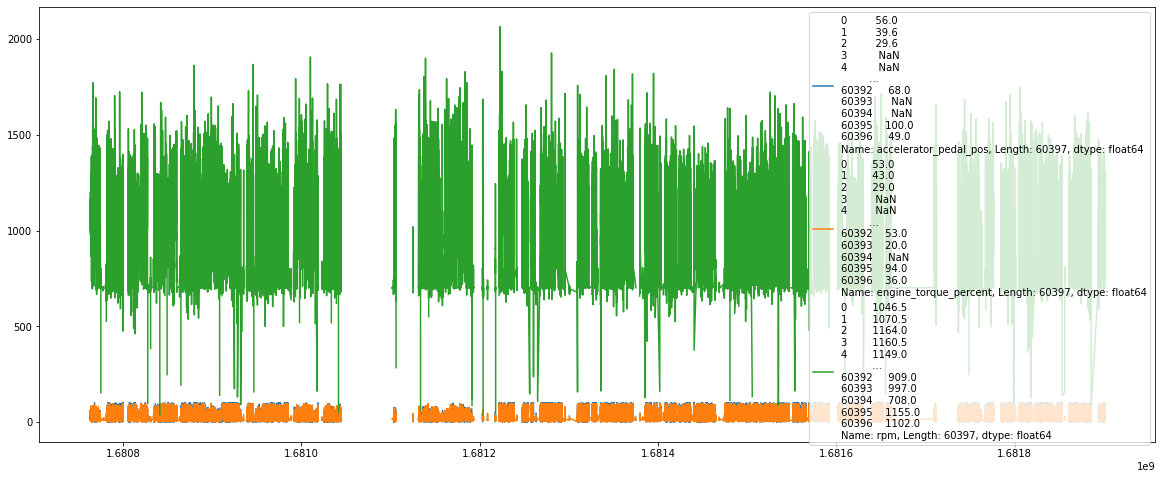

In [7]:
## First we will do missing value imputation then go for EDA, otherwise EDA wont be formed for consecutive data
# Mean Value imputation technique for Random values of attributes

mean_attributes = ['accelerator_pedal_pos',
       'engine_torque_percent', 'rpm']

plt.figure(figsize=(20, 8))
for column in data[mean_attributes]:
    plt.plot(data['ts'],data[column],label=data[column])
plt.legend()
plt.show()

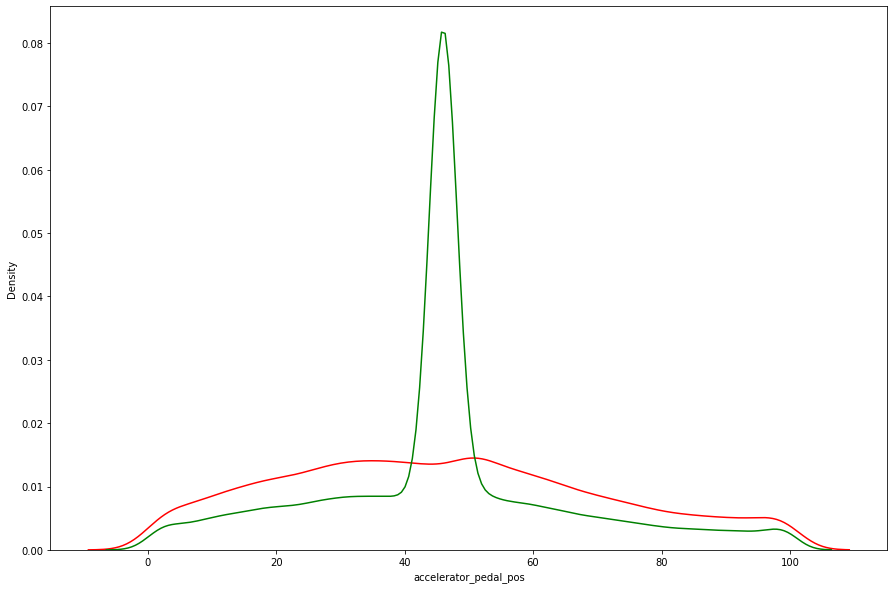

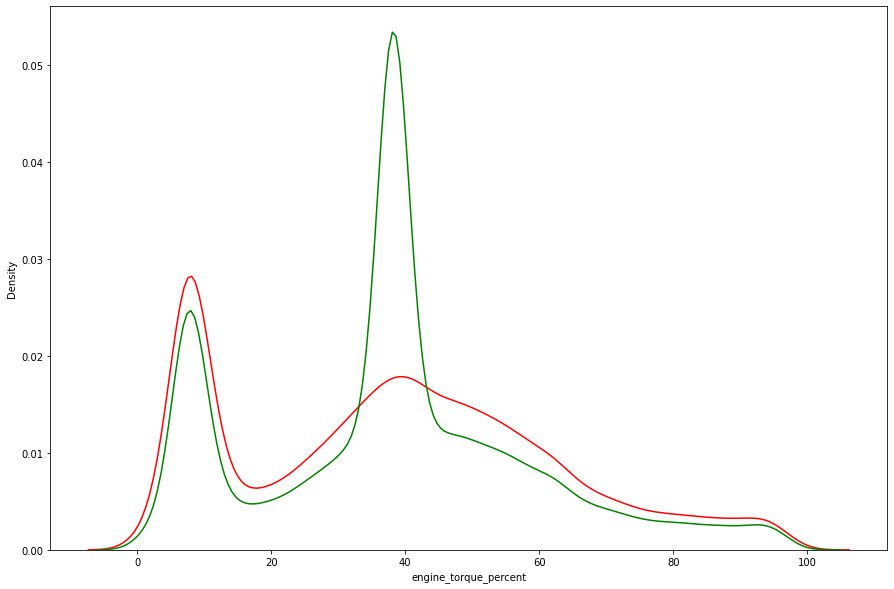

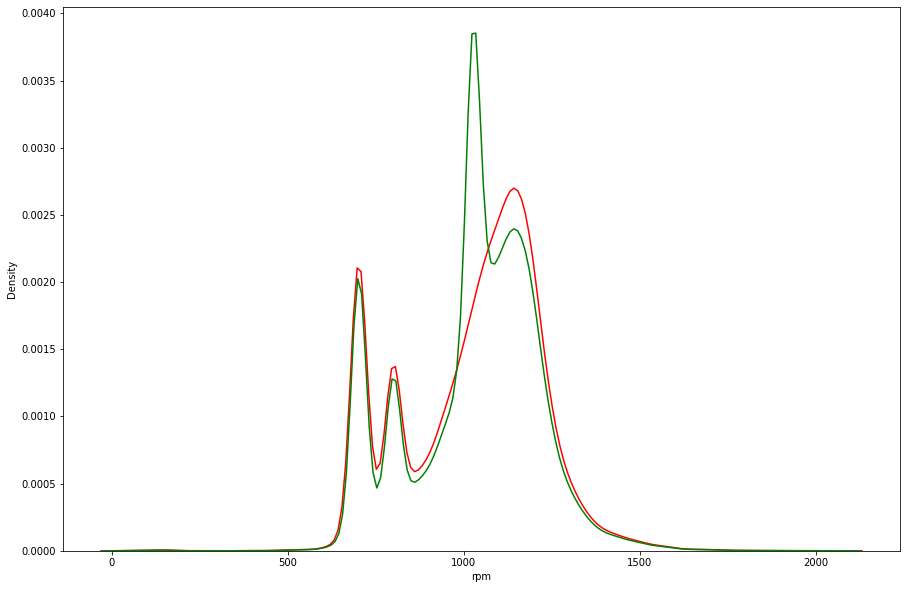

In [8]:
# Mean Imputation
data_mean_imputed = data.copy()
for column in data[mean_attributes]:
    data_mean_imputed[column].fillna(data[column].mean(), inplace=True)
    
# Comparartive graph before and After imputation
for column in data[mean_attributes]:
    plt.figure(figsize=(15, 10))
    sns.kdeplot(data[column], label='Original',color='red',alpha=0.6)
    sns.kdeplot(data_mean_imputed[column], label='Imputed',color='green',alpha=0.4)
    plt.show()

In [9]:
data_mean_imputed.isnull().sum().sort_values(ascending=False).keys()[:6]

Index(['fuel_consumption', 'fuel_rate', 'fuel_economy', 'fuel_level',
       'obddistance', 'runtime'],
      dtype='object')

In [10]:
# KNN imputation

knn_attributes = ['fuel_rate', 'fuel_economy', 'fuel_level','obddistance', 'runtime']


imputer = KNNImputer(n_neighbors=5)
data_knn_imputed = pd.DataFrame(imputer.fit_transform(data[knn_attributes]), columns=knn_attributes)

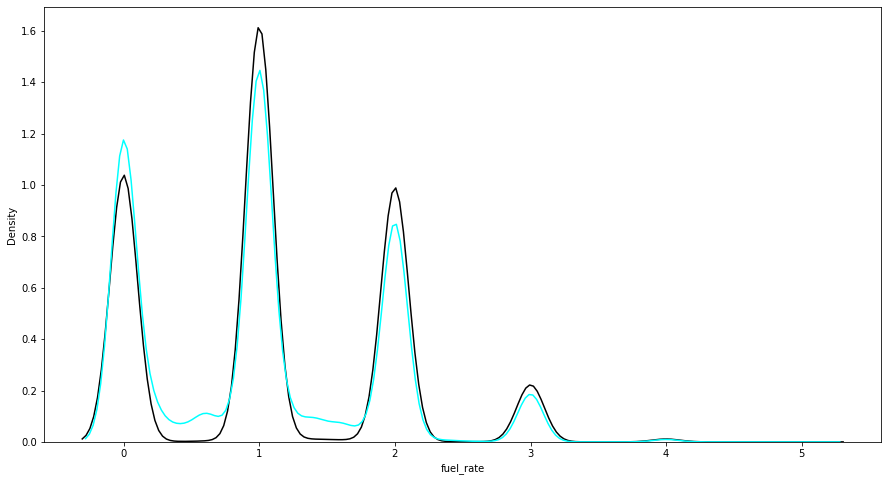

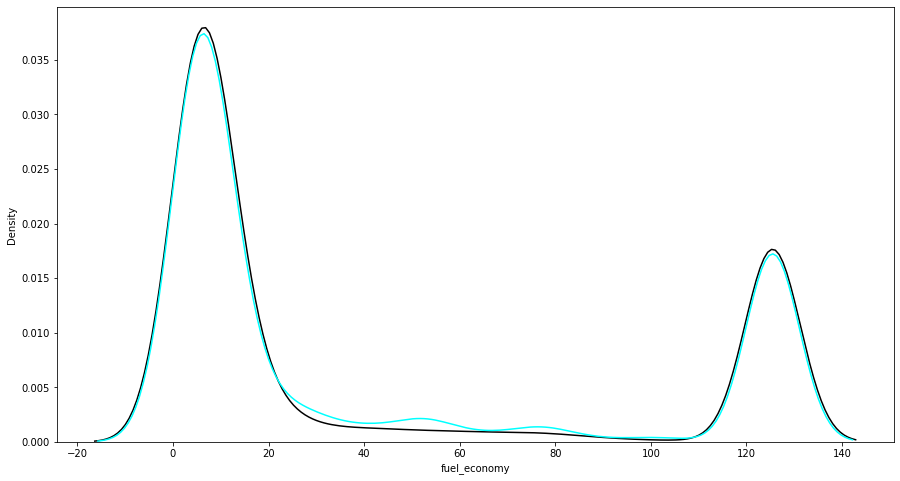

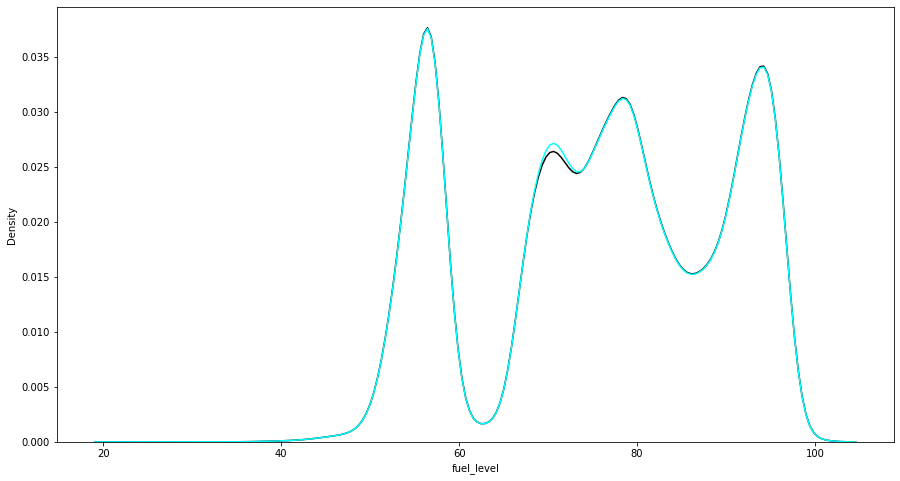

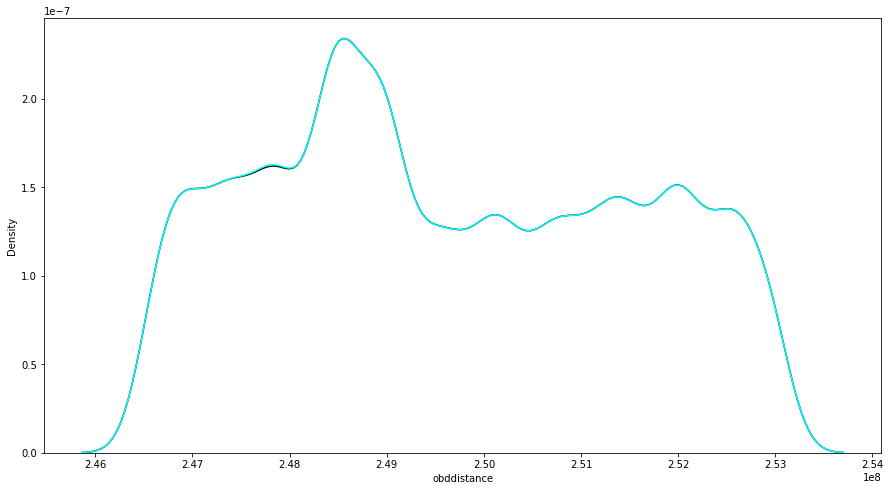

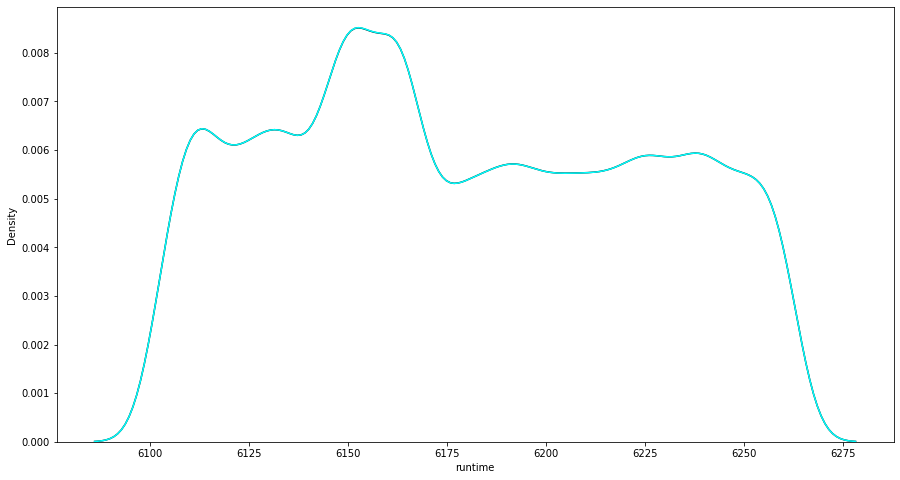

In [11]:
for column in data[knn_attributes]:
    
    plt.figure(figsize=(15, 8))
    sns.kdeplot(data[column], label=f'Original {column}',color='black',alpha=0.6)
    sns.kdeplot(data_knn_imputed[column], label=f'Imputed {column}',color='cyan',alpha=0.4)
    plt.show()

In [12]:
data_mean_imputed.drop(knn_attributes,axis=1,inplace=True)
final_imputed_df = pd.concat([data_mean_imputed,data_knn_imputed],axis=1)
final_imputed_df.isnull().sum()

ts                                0
lat                               0
lng                               0
rpm                               0
engine_torque_percent             0
fuel_consumption              60397
accelerator_pedal_pos             0
engine_throttle_valve2_pos        0
enginefueltemp                    0
engine_airlet_pressure            0
accelerator_pedal_pos_2           0
fuel_rate                         0
fuel_economy                      0
fuel_level                        0
obddistance                       0
runtime                           0
dtype: int64

## Attributes values conversion for better EDA

In [13]:
# Conversion of attributes

final_imputed_df['Covered_dist(Km)']= np.round(final_imputed_df['obddistance']/1000,3)
final_imputed_df['Remaining_Fuel_AMT(ltr)'] = 425*(final_imputed_df['fuel_level']/100)
final_imputed_df['fuel_economy(km/ltr)'] = final_imputed_df['fuel_economy']*0.84
final_imputed_df['fuel_consumption'] = final_imputed_df['fuel_rate']*final_imputed_df['Covered_dist(Km)']
final_imputed_df.drop(['obddistance','fuel_level','fuel_economy'],axis=1,inplace=True)

### Univariate EDA

In [14]:
final_imputed_df['Covered_dist(Km)'].describe()

count     60397.000000
mean     249641.231357
std        1865.532450
min      246484.496000
25%      248121.056000
50%      249402.816000
75%      251299.104000
max      253079.248000
Name: Covered_dist(Km), dtype: float64

In [15]:
final_imputed_df.columns

Index(['ts', 'lat', 'lng', 'rpm', 'engine_torque_percent', 'fuel_consumption',
       'accelerator_pedal_pos', 'engine_throttle_valve2_pos', 'enginefueltemp',
       'engine_airlet_pressure', 'accelerator_pedal_pos_2', 'fuel_rate',
       'runtime', 'Covered_dist(Km)', 'Remaining_Fuel_AMT(ltr)',
       'fuel_economy(km/ltr)'],
      dtype='object')

#### 1. Fuel Economy Column exploration

<Axes: xlabel='fuel_economy(km/ltr)', ylabel='Count'>

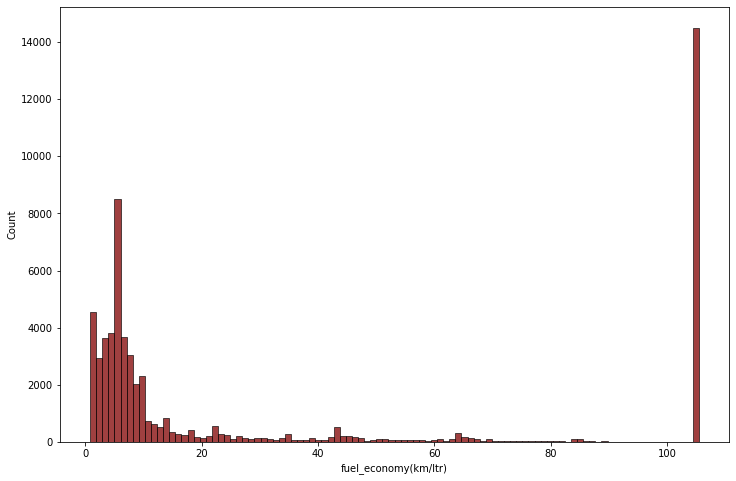

In [16]:
plt.figure(figsize=(12,8))
sns.histplot(final_imputed_df['fuel_economy(km/ltr)'],bins=100,color='maroon')

There are some extreme noticable values can be seen above 100 for fuel economy, that's a little unrealistic. We need to scale them down to some relevant data range

<Axes: xlabel='fuel_economy(km/ltr)', ylabel='Count'>

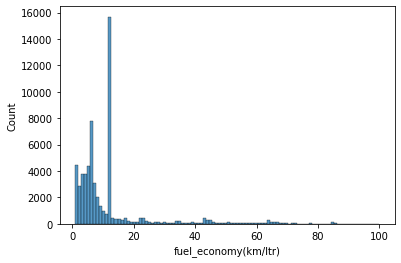

In [17]:
# Fix the fuel_economy column extreme values  (>100)

# Calculating the mean value (excluding the extreme values)
mean_value = final_imputed_df[final_imputed_df['fuel_economy(km/ltr)'] < 100]['fuel_economy(km/ltr)'].mean()

# Scale down the extreme value by replacing it with the mean value of < 100 datapoints
final_imputed_df.loc[final_imputed_df['fuel_economy(km/ltr)'] >100, 'fuel_economy(km/ltr)'] = mean_value
sns.histplot(final_imputed_df['fuel_economy(km/ltr)'],bins=100)

C:\Users\Manjima Dutta\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='fuel_economy(km/ltr)'>

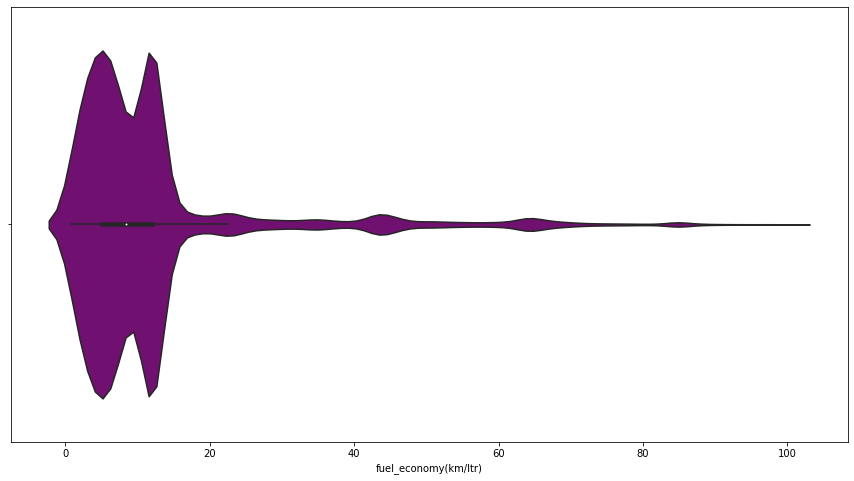

In [18]:
plt.figure(figsize=(15,8))
sns.violinplot(final_imputed_df['fuel_economy(km/ltr)'],color='purple')

#### 2. Runtime attribute exploration

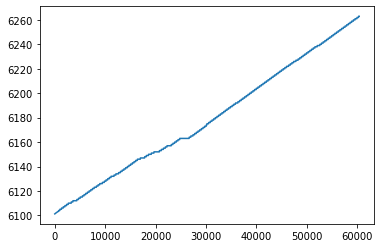

In [19]:
plt.plot(final_imputed_df['runtime'])

Well, that seems a pretty good upward reliable line cause Runtime keeps increasing with time.

C:\Users\Manjima Dutta\anaconda3\lib\site-packages\seaborn\relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


<Axes: xlabel='runtime', ylabel='Covered_dist(Km)'>

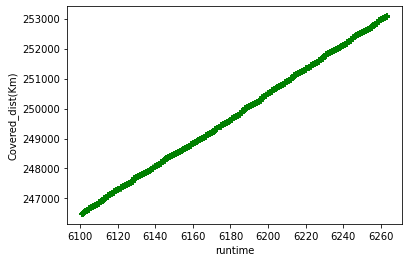

In [20]:
# Checking relation between runtime and Covered Distance

sns.scatterplot(data=final_imputed_df,x='runtime',y='Covered_dist(Km)',color='g',marker='+')

#### 3. Fuel rate attribute exploration

<Axes: xlabel='fuel_rate', ylabel='Count'>

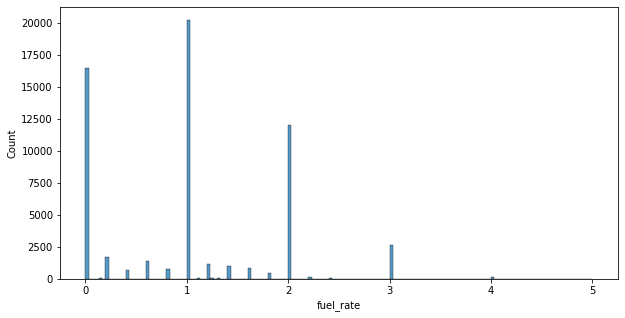

In [21]:
plt.figure(figsize=(10,5))
sns.histplot(final_imputed_df['fuel_rate'],bins=150)

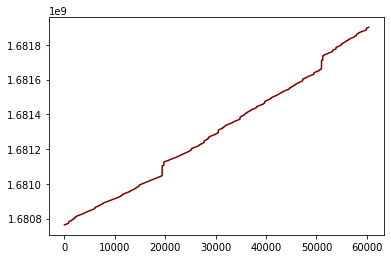

In [22]:
plt.plot(final_imputed_df['ts'],color='maroon')

<Axes: xlabel='fuel_consumption', ylabel='Count'>

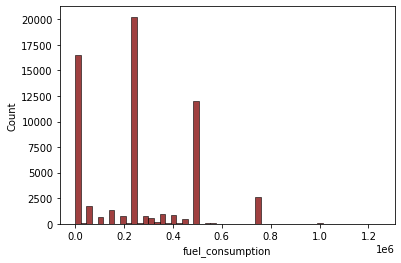

In [23]:
sns.histplot(final_imputed_df['fuel_consumption'],color='maroon')

### Pairwise EDA

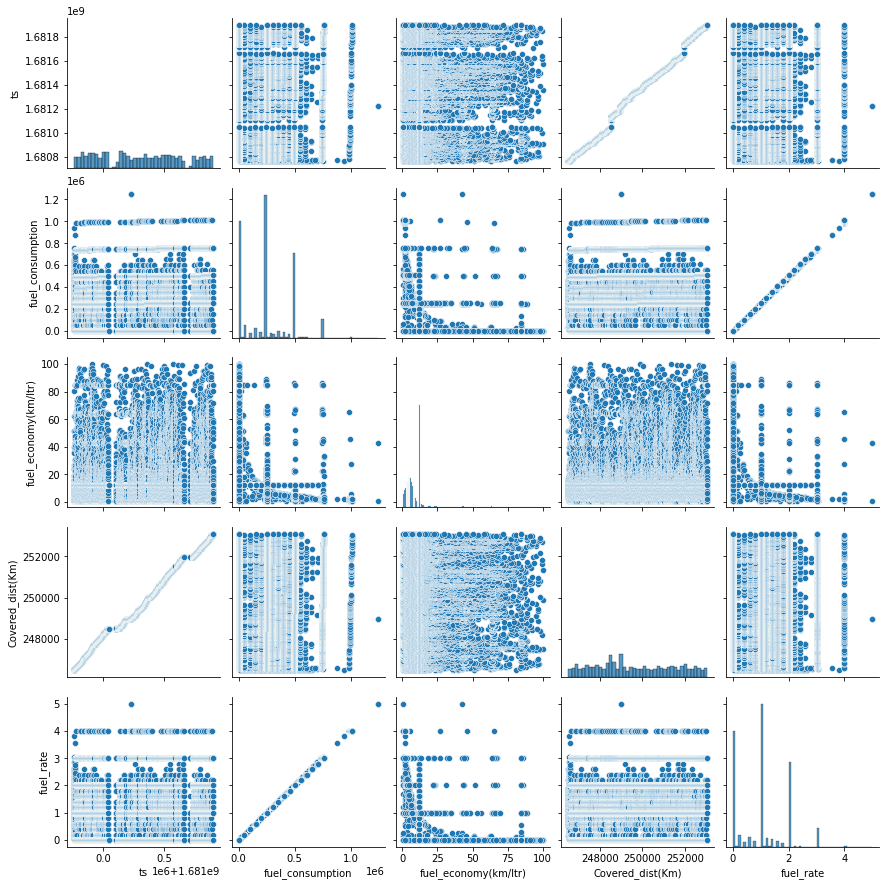

In [24]:
sns.pairplot(final_imputed_df[['ts','fuel_consumption','fuel_economy(km/ltr)','Covered_dist(Km)','fuel_rate']])
plt.show()

Text(0.5, 1.0, 'Vehicle data features correlation graph')

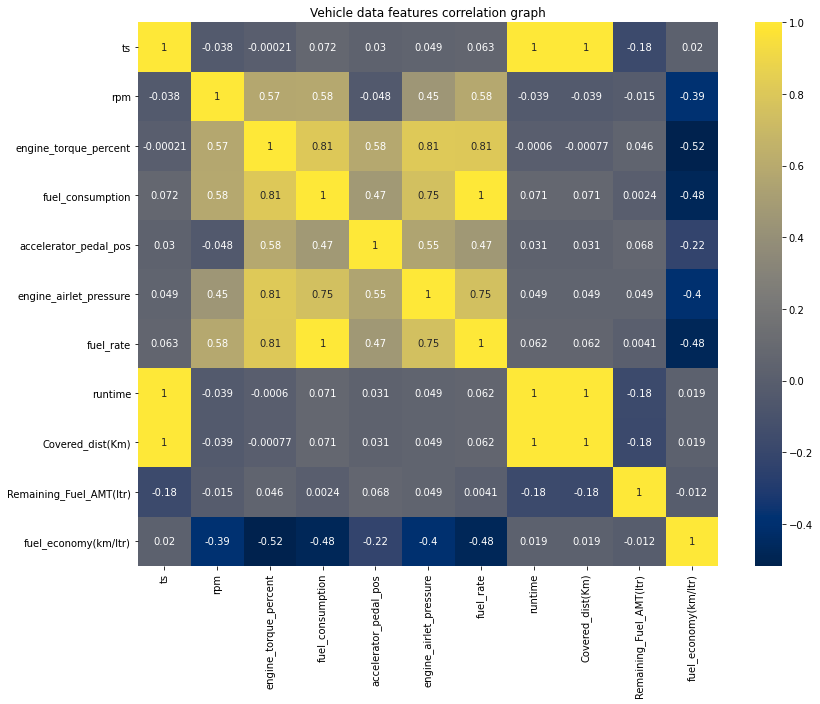

In [26]:
plt.figure(figsize=(13,10))
heatmap=sns.heatmap(final_imputed_df.drop(['lat','lng','engine_throttle_valve2_pos','enginefueltemp','accelerator_pedal_pos_2'],axis=1).corr(),cmap='cividis',annot=True)


heatmap.set_title('Vehicle data features correlation graph')

We can observe strong correlation values coming from few of the predictor attributes, that can't be good. We need to scale them down. Here we apply one dimension reduction technique called 'PCA' to lower this crisis

In [27]:
# First we drop some of the redundant features

final_imputed_df.drop(['lat','lng','engine_throttle_valve2_pos','enginefueltemp','accelerator_pedal_pos_2'],axis=1,inplace=True)

## Feature Engineering & Some Detailed EDA

In [28]:
eda_df = final_imputed_df.copy()
# eda_df['ts'] = eda_df['ts'].astype(int)
eda_df['Time'] = [datetime.datetime.fromtimestamp(i).strftime('%H:%M:%S') for i in eda_df['ts']]
eda_df['Year'] = [datetime.datetime.fromtimestamp(i).strftime('%Y') for i in eda_df['ts']]
eda_df['Month'] = [datetime.datetime.fromtimestamp(i).strftime('%b') for i in eda_df['ts']]
eda_df['Date_of_Month'] = [datetime.datetime.fromtimestamp(i).strftime('%d') for i in eda_df['ts']]

In [29]:
days=[pd.to_datetime(datetime.datetime.fromtimestamp(i)).day_name() for i in eda_df['ts']]
eda_df['Day_Type'] = ['Weekend' if i in ['Saturday','Sunday'] else 'Weekdays' for i in days]
eda_df['Day_Type'].value_counts()

Weekdays    39220
Weekend     21177
Name: Day_Type, dtype: int64

In [30]:
eda_df['Time_of_Day']=['AM' if int(i.split(':')[0])<12 else 'PM' for i in eda_df['Time']]

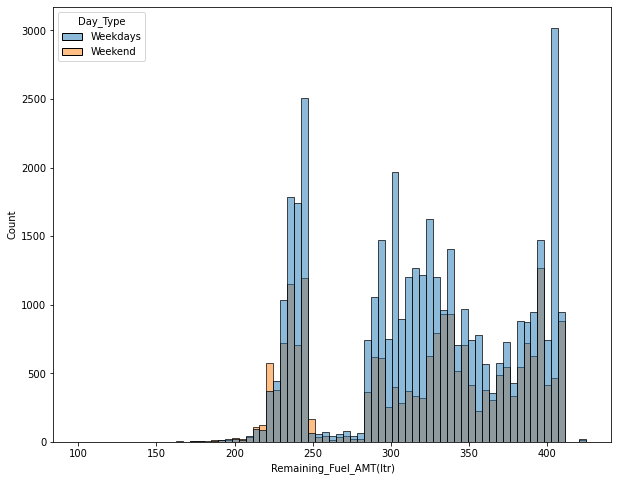

In [31]:
plt.figure(figsize=(10,8))
sns.histplot(data=eda_df, x=eda_df['Remaining_Fuel_AMT(ltr)'], hue=eda_df['Day_Type'], kde=False)
plt.show()

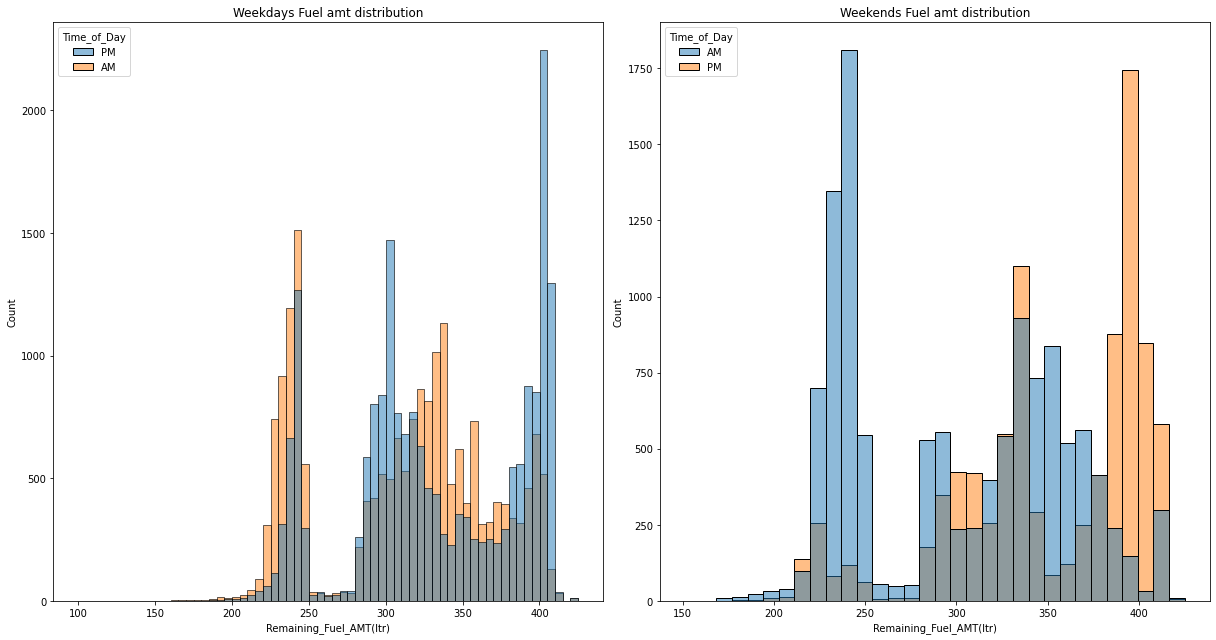

In [32]:
weekday = eda_df.query("Day_Type=='Weekdays'")
weekend = eda_df.query("Day_Type=='Weekend'")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 9))
sns.histplot(data=weekday, x=weekday['Remaining_Fuel_AMT(ltr)'], hue=weekday['Time_of_Day'], kde=False,ax=ax1)
ax1.set_title('Weekdays Fuel amt distribution')
sns.histplot(data=weekend, x=weekend['Remaining_Fuel_AMT(ltr)'], hue=weekend['Time_of_Day'], kde=False,ax=ax2)
ax2.set_title('Weekends Fuel amt distribution')

plt.tight_layout()
plt.show()

## Data Preprocessing and Scaling

In [33]:
X = final_imputed_df.drop('Remaining_Fuel_AMT(ltr)',axis=1)
Y = final_imputed_df['Remaining_Fuel_AMT(ltr)']

In [34]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

pca = PCA(n_components=8)  # Choose the number of components to retain
pca_data = pca.fit_transform(X)

In [35]:
n_components = pca.n_components_
column_names = [f'PC_{i+1}' for i in range(n_components)]
X_ = pd.DataFrame(pca_data,columns=column_names)

In [36]:
scaler = StandardScaler()
X_1 = pd.DataFrame(scaler.fit_transform(X_),columns=X_.columns)

### Modelling

In [37]:
# Splitting of dataset for the model training

X_train, X_test, y_train, y_test = train_test_split(X_1, Y, test_size=0.25, random_state=42)
X_train.columns

Index(['PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6', 'PC_7', 'PC_8'], dtype='object')

In [38]:
# searching for best parameters combination for prediction using GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

pipeline = Pipeline([('regressor', XGBRegressor())])

hyperparameters = {
    'regressor__learning_rate': [0.01, 0.1, 0.5],
    'regressor__max_depth': [3, 5, 7],
    'regressor__n_estimators': [50, 100, 150],
    'regressor__subsample': [0.5, 0.7, 1.0],
    'regressor__colsample_bytree': [0.5, 0.7, 1.0],
}

# perform a grid search over the hyperparameters
grid_search = GridSearchCV(pipeline, hyperparameters, cv=5)

In [39]:
# model fit for finding out the best parameter set for model training

grid_search.fit(X_train, y_train)

# print the best hyperparameters and model score
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best score: {}'.format(grid_search.best_score_))

Best parameters: {'regressor__colsample_bytree': 1.0, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 7, 'regressor__n_estimators': 150, 'regressor__subsample': 1.0}
Best score: 0.9256646780523852


In [40]:
# now fit the model using best parameters and evaluate for better conclusion

best_params = grid_search.best_params_

xgb_best = XGBRegressor(random_state=42, **best_params)
xgb_best.fit(X_train, y_train)

[12:20:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "regressor__colsample_bytree", "regressor__learning_rate", "regressor__max_depth", "regressor__n_estimators", "regressor__subsample" } are not used.



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [41]:
y_pred = xgb_best.predict(X_test)

In [42]:
from sklearn.metrics import r2_score

# y_test are the actual target values and y_pred are the predicted target values

r2_score(y_test, y_pred)

0.9235464856646416

In [43]:
# Regularization technique use for betterment of the result

l1_model = XGBRegressor(random_state=42,reg_alpha=0.2, **best_params)     # best
l1_model.fit(X_train, y_train)
y_pred_l1 = l1_model.predict(X_test)

mse_l1 = mean_squared_error(y_test, y_pred_l1)

print("R Squared Error: ", r2_score(y_test, y_pred_l1))


[12:21:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "regressor__colsample_bytree", "regressor__learning_rate", "regressor__max_depth", "regressor__n_estimators", "regressor__subsample" } are not used.

R Squared Error:  0.9249847056067969


In [44]:
# Entire dataset prediction

f_prediction_y = l1_model.predict(X_1)
print(r2_score(Y , f_prediction_y))

0.9471848042722105


In [45]:
final_imputed_df['Predicted_Fuel_Amt'] = f_prediction_y

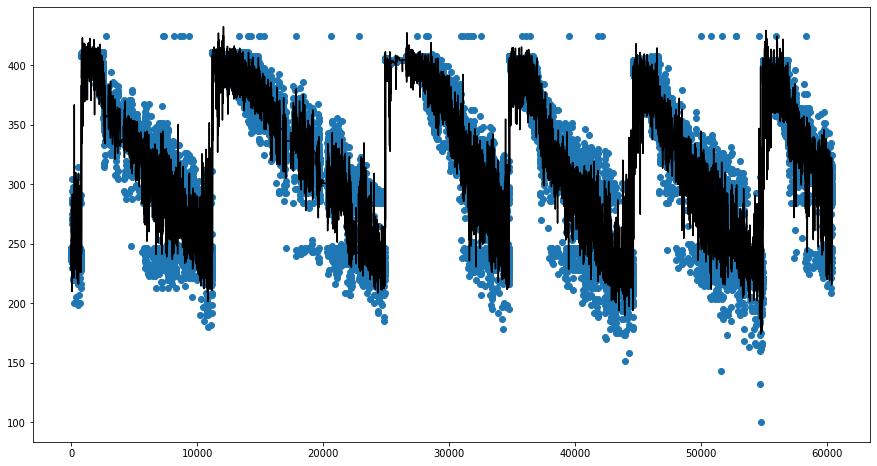

In [46]:
plt.figure(figsize=(15,8))
plt.plot(final_imputed_df['Remaining_Fuel_AMT(ltr)'],'o',label='Original Data')

plt.plot(final_imputed_df['Predicted_Fuel_Amt'],'-', color='black',label='Fitted Line')

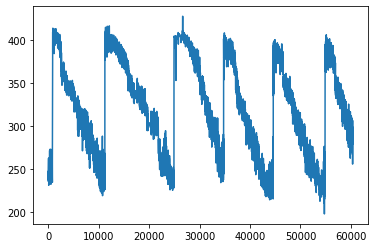

In [47]:
# reduce noisy data using Moving Average(MA) , EMA


# OVER PREDICTION

final_imputed_df['smoothed_ma'] = final_imputed_df['Predicted_Fuel_Amt'].rolling(window=5).mean()
plt.plot(final_imputed_df['smoothed_ma'])

### Now, our utmost vision is to see whether we can detect these change points in fuel amount trend curve or not, and perfectly categorize it into fuel fill and fuel theft cases. 

**"Change Finder" package for CPD (Change Point Detection for Varying variance using SDAR concept)**

60387

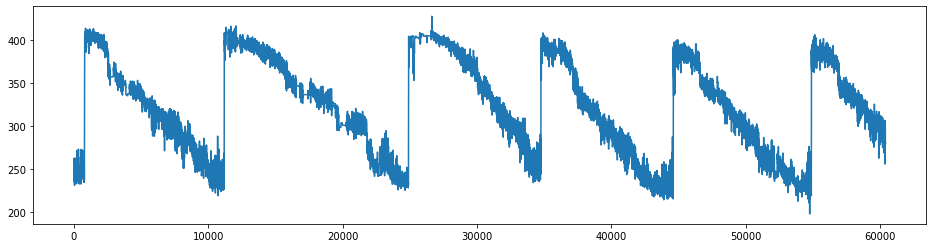

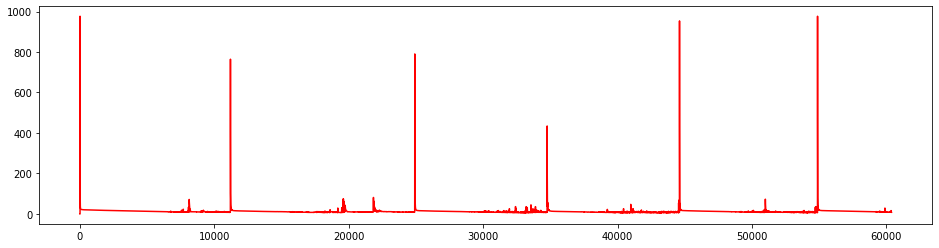

In [48]:


points=final_imputed_df[['smoothed_ma']].iloc[10:,:].values   # using a sample for easy processing and memory save purpose 


def findChangePoints(ts):
   
    cf = ChangeFinder(r=0.0009)
    ts_score = [cf.update(p) for p in ts]
    plt.figure(figsize=(16,4))
    plt.plot(ts)
    plt.figure(figsize=(16,4))
    plt.plot(ts_score, color='red')
    
    return(ts_score)
    
ts_score1 = findChangePoints(points)
len(ts_score1)

### We have been able to capture all the varying points coming from Fuel trend graph. High peaks in red curve shows the change points in the above blue plot

In [49]:
# Now getting the indices of the highest peaks to find out same positioned values from oroginal data

from scipy.signal import find_peaks

indices = find_peaks(ts_score1,height=300)[0]
print(indices)
points[indices].squeeze()

[   11 11201 24915 34764 44611 54881]


array([244.48093872, 402.70257568, 404.14005737, 388.62797852,
       385.95076904, 368.71394043])

In [50]:
df_New = final_imputed_df.iloc[10:,:]
y_scatter = [df_New['smoothed_ma'].tolist()[i] for i in indices]
x_scatter = [df_New['Covered_dist(Km)'].tolist()[i] for i in indices]

<ipython-input-51-472ec9d4f6f1>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


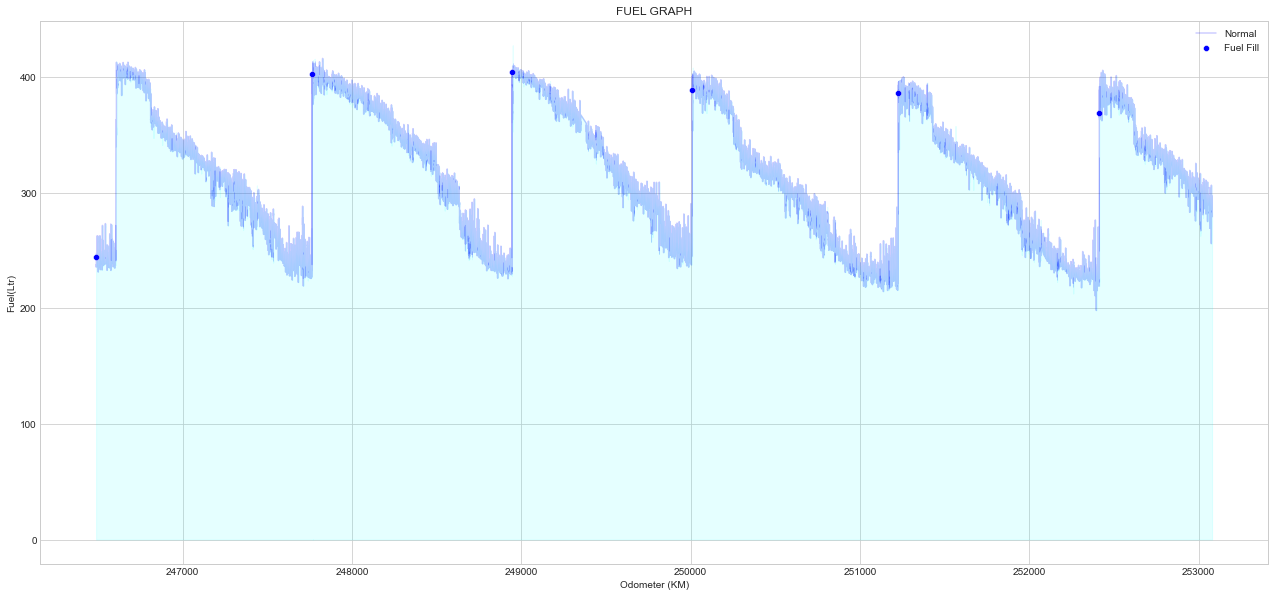

In [51]:
# Visualation of Change Points properly on Fuel trend on basis of Covered Distances

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(22,10))
sns.lineplot(data=df_New, x='Covered_dist(Km)', y='smoothed_ma',color='blue',alpha=0.2,label='Normal')
plt.fill_between(df_New['Covered_dist(Km)'], df_New['smoothed_ma'], 0, color='cyan',alpha=0.1)
sns.scatterplot(x=x_scatter,y=y_scatter,label='Fuel Fill',color='blue',sizes=[800]*6,marker='o')
plt.title('FUEL GRAPH')
plt.xlabel('Odometer (KM)')
plt.ylabel('Fuel(Ltr)')
plt.show()